In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import os

In [2]:
# x 7680,  y 1024 
def get_tile_path(x, y, band, date):
    path = f'C:\\Users\\Gladiator\\Documents\\Good_Crop_Bad_Crop\\model\\satelite_data\\phase-01\\data\\sentinel-2a-tile-{x}x-{y}y\\timeseries\\{x}-{y}-{band}-{date}.png'
    return path

In [3]:
# get the picture
def get_image(x, y, band, date):
    path = get_tile_path(x,y,band,date)
    im = image.imread(path)
    return im

In [4]:
# get the dates
paths = glob.glob(get_tile_path('7680','10240','B01','*'))
dates = []
for path in paths:
    x = len(path)
    dates.append(path[x-14:x-4])
    
# sort date  
dates.sort(key= lambda x: int(''.join(x.split('-'))))

dates[0:5]

['2016-12-22', '2017-01-01', '2017-01-11', '2017-02-10', '2017-02-20']

In [5]:
def calulcate_NVDI(NIR, RED):
    return (NIR - RED) / (NIR + RED)

In [6]:
def calculate_ENVDI(NIR, GREEN, BLUE):
    return ((NIR+GREEN) - (2*BLUE)) / ((NIR+GREEN) + (2*BLUE)) 

In [7]:
def calulcate_GNDVI(NIR, GREEN):
    
    return (NIR - GREEN) / (NIR + GREEN)

def calculate_SIPI(NIR, RED, BLUE):
    division = NIR - RED
    for i in range(0, len(division)):
        for j in range(0, len(division[i])):
            if division[i,j] == 0:
                division[i,j] = np.min(division[i])
    print(NIR -BLUE)
    print(division)
    result = ((NIR - BLUE) / (division))
    return result

In [8]:
def get_wavelength(x, y, band, date):
    im = Image.open(get_tile_path(x,y,band,date))
    arr = np.array(im.getdata()).reshape(512,512)
    return arr

In [9]:
def get_partition(image, xStart, yStart, mask):
    result = [] 
    for y in range(0, len(mask)):
        for x in range(0, len(mask[0])):
            # check if the mask pixel is selected then add the img pixel to list
            if mask[y,x]==1:
                result.append(image[yStart+y, xStart+x])
    return np.array(result)

In [10]:
def get_avg_vegetation_index(vi, X, Y, xStart, yStart, mask):
    result = []
    avg = []
    upper = []
    lower = []
    for date in dates[0:12]:
        red = get_wavelength(X,Y,RED,date)
        blue = get_wavelength(X,Y,BLUE,date)
        green = get_wavelength(X,Y,GREEN,date)
        nir = get_wavelength(X,Y,NIR,date)
        
        if vi == 'NVDI':
            nvdi = calulcate_NVDI(nir, red)
            res = get_partition(nvdi, xStart, yStart, mask)
            average = np.average(res)
            sd = np.std(res)

            avg.append(average)
            upper.append(average+(2*sd))
            lower.append(average-(2*sd))
            result.append(res)
    dict = {}
    dict['result'] = result
    dict['avg'] = avg
    dict['upper'] = upper
    dict['lower'] = lower
    return dict

In [16]:
BLUE = 'B02'
GREEN = 'B03'
RED = 'B04'
NIR = 'B08'

In [17]:
X = '7680'
Y = '10240'
xStart = 0
yStart = 0
mask = np.ones((20,20))

In [18]:
temp = get_avg_vegetation_index('NVDI', X, Y, xStart, yStart, mask)

In [19]:
xlabels = [] 
result = []
xlabel2 = []
for i in range(0, len(temp['result'])):
    xlabel2.append(i)
    for res in temp['result'][i]:
        result.append(res)
        xlabels.append(i)

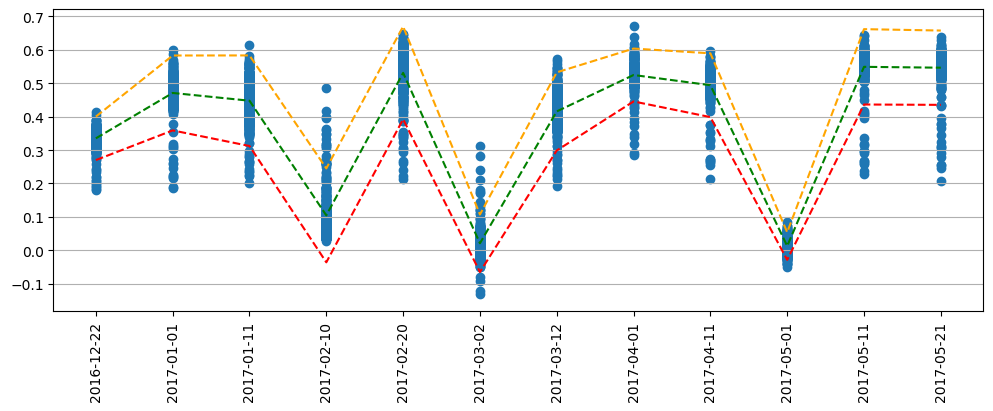

In [20]:
plt.figure(figsize=(12,4), dpi=100)

plt.scatter(xlabels, result, marker='o')

plt.xticks(xlabel2, dates[0:12])
plt.xticks(rotation=90)

# plt.title('Average Sub-tile Value')
plt.grid(axis='y')
plt.yticks(np.arange(-0.5, 1.5, step=0.1))
# plt.xlabel('Dates')
# plt.ylabel('VALUE')
plt.plot(xlabel2,temp['avg'], color='green', linestyle='dashed', label='Average')
plt.plot(xlabel2,temp['upper'], color='orange', linestyle='dashed', label='Upper')
plt.plot(xlabel2,temp['lower'], color='red', linestyle='dashed', label='Lower')
plt.show()

In [28]:
df = pd.DataFrame({'Stage': xlabel2, 'Average': temp['avg'], 'Upper': temp['upper'], 'Lower': temp['lower']})
df


,Stage,Average,Upper,Lower
0,0,0.335039,0.400076,0.270003
1,1,0.470764,0.582747,0.358782
2,2,0.447569,0.583024,0.312114
3,3,0.104673,0.245105,-0.035758
4,4,0.530830,0.669604,0.392057
5,5,0.021246,0.107256,-0.064764
6,6,0.415588,0.532408,0.298769
7,7,0.524451,0.603528,0.445375
8,8,0.493938,0.589314,0.398561
9,9,0.012922,0.054236,-0.028393


In [34]:
import plotly.express as px
labels={"value": "Average", "variable": 'Statistic'}
fig = px.line(df, x='Stage', y=df.columns, labels=labels)
#fig.add_scatter()
fig.update_layout(autosize=True)

fig.show()
